# Names, title, etc

In [1]:
from perform_kickstarer_eda import *


ks_data shape: (20632, 68)
Categorical columns: ['country', 'currency', 'deadline', 'state_changed_at', 'created_at', 'launched_at', 'category', 'deadline_weekday', 'state_changed_at_weekday', 'created_at_weekday', 'launched_at_weekday', 'launch_to_deadline', 'launch_to_state_change']
Converted boolean column: staff_pick
Dropped 'state_changed_at_weekday' column
Dropping original column: category
Encoded column: category → 25 features
Dropping original column: deadline_weekday
Encoded column: deadline_weekday → 7 features
Dropping original column: created_at_weekday
Encoded column: created_at_weekday → 7 features
Dropping original column: launched_at_weekday
Encoded column: launched_at_weekday → 7 features
Total categorical columns after encoding: 54


5 features: R² = 0.1651
Selected features: ['goal', 'staff_pick', 'create_to_launch_days', 'launch_to_state_change_days', 'created_at_hr']
10 features: R² = 0.2501
Selected features: ['goal', 'staff_pick', 'create_to_launch_days', 'launch_to_state_change_days', 'created_at_hr', 'created_at_day', 'name_len_clean', 'blurb_len_clean', 'launched_at_day', 'launched_at_hr']
15 features: R² = 0.2956
Selected features: ['goal', 'staff_pick', 'create_to_launch_days', 'launch_to_state_change_days', 'created_at_hr', 'created_at_day', 'name_len_clean', 'blurb_len_clean', 'launched_at_day', 'launched_at_hr', 'category_Web', 'launch_to_deadline_days', 'state_changed_at_day', 'deadline_hr', 'deadline_day']
20 features: R² = 0.3108
Selected features: ['goal', 'staff_pick', 'create_to_launch_days', 'launch_to_state_change_days', 'created_at_hr', 'created_at_day', 'name_len_clean', 'blurb_len_clean', 'launched_at_day', 'launched_at_hr', 'category_Web', 'launch_to_deadline_days', 'state_changed_at_day', 

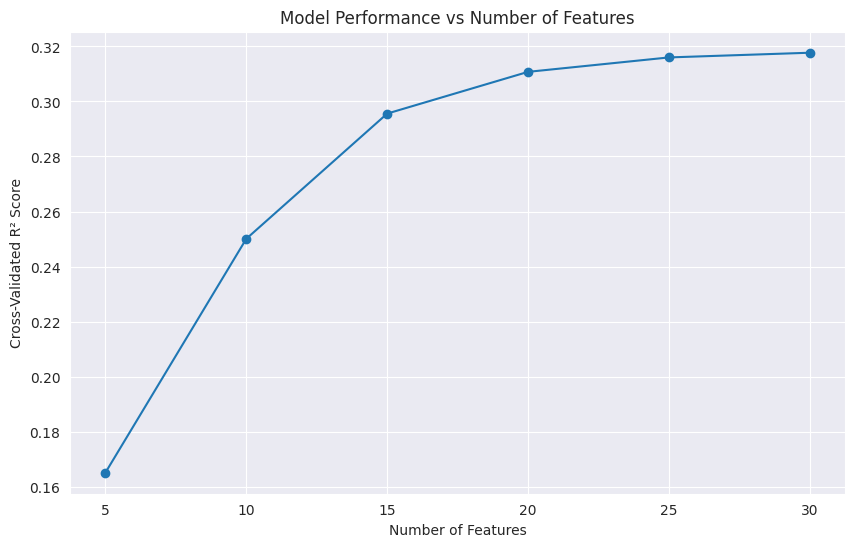


Optimal number of features: 30
Selected features: ['goal', 'staff_pick', 'create_to_launch_days', 'launch_to_state_change_days', 'created_at_hr', 'created_at_day', 'name_len_clean', 'blurb_len_clean', 'launched_at_day', 'launched_at_hr', 'category_Web', 'launch_to_deadline_days', 'state_changed_at_day', 'deadline_hr', 'deadline_day', 'state_changed_at_hr', 'created_at_month', 'category_Software', 'launched_at_month', 'deadline_month', 'state_changed_at_month', 'category_Hardware', 'launched_at_weekday_Tuesday', 'created_at_weekday_Tuesday', 'category_None', 'created_at_weekday_Monday', 'created_at_weekday_Friday', 'created_at_weekday_Thursday', 'category_Plays', 'created_at_weekday_Wednesday']


KeyboardInterrupt: 

In [2]:
from numpy import ndarray, argsort
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def get_rf_feature_importance(_X_train: DataFrame, _y_train: ndarray, n_features: int = 10) -> list:
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(_X_train, _y_train)

    # Get feature importances
    importances = rf.feature_importances_
    indices = argsort(importances)[::-1]

    # Select top n features
    top_features = _X_train.columns[indices[:n_features]].tolist()
    return top_features, indices


def get_rfe_features(_X_train: DataFrame, _y_train: ndarray, n_features: int = 10) -> list:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    rfe.fit(_X_train, _y_train)

    # Get selected features
    selected_features = _X_train.columns[rfe.support_].tolist()
    return selected_features

# Method 3: Statistical feature selection
def get_statistical_features(_X_train: DataFrame, _y_train: ndarray, n_features: int = 10) -> list:
    selector = SelectKBest(score_func=f_regression, k=n_features)
    selector.fit(_X_train, _y_train)

    # Get selected features
    selected_mask = selector.get_support()
    selected_features = _X_train.columns[selected_mask].tolist()
    return selected_features

# Get ordered features and indices from Random Forest
top_features, importance_indices = get_rf_feature_importance(X_train, y_train, len(X_train.columns))
ranked_features = X_train.columns[importance_indices].tolist()

# Define range of feature counts to test
feature_counts = [30, 40, 50, 60]
if len(ranked_features) < 30:
    feature_counts = list(range(5, len(ranked_features)+1, 5))

# Test different feature counts
cv_scores = []
for n_features in feature_counts:
    if n_features > len(ranked_features):
        continue

    # Select top n features
    selected_features = ranked_features[:n_features]
    X_selected = X_train[selected_features]

    # Evaluate with cross-validation
    scores = cross_val_score(
        RandomForestRegressor(n_estimators=100, random_state=42),
        X_selected, y_train,
        cv=5, scoring='r2'
    )

    cv_scores.append(scores.mean())
    print(f"{n_features} features: R² = {scores.mean():.4f}")
    print(f"Selected features: {selected_features}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(feature_counts[:len(cv_scores)], cv_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated R² Score')
plt.title('Model Performance vs Number of Features')
plt.grid(True)
plt.savefig('feature_selection_curve.png')
plt.show()

# Find the optimal number based on the results
optimal_idx = max(range(len(cv_scores)), key=cv_scores.__getitem__)
optimal_n_features = feature_counts[optimal_idx]
print(f"\nOptimal number of features: {optimal_n_features}")
print(f"Selected features: {ranked_features[:optimal_n_features]}")

# For comparison, also get features using RFE and Statistical methods
rfe_features = get_rfe_features(X_train, y_train, optimal_n_features)
stat_features = get_statistical_features(X_train, y_train, optimal_n_features)

print(f"\nRandom Forest selected {optimal_n_features} features: {ranked_features[:optimal_n_features]}")
print(f"RFE selected {optimal_n_features} features: {rfe_features}")
print(f"Statistical selection selected {optimal_n_features} features: {stat_features}")

# Find common features across all methods
common_features = set(ranked_features[:optimal_n_features]) & set(rfe_features) & set(stat_features)
print(f"\nFeatures selected by all methods: {common_features}")

Fitting 5 folds for each of 63 candidates, totalling 315 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Test Accuracy: 0.7620

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      2902
           1       0.66      0.40      0.50      1224

    accuracy                           0.76      4126
   macro avg       0.72      0.66      0.67      4126
weighted avg       0.75      0.76      0.74      4126


Confusion Matrix:
[[2649  253]
 [ 729  495]]

Feature Importance:
                        Feature  Importance
0                          goal    0.149822
2   launch_to_state_change_days    0.085982
1         create_to_launch_days    0.073780
9                  category_Web    0.062926
10      launch_to_deadline_days    0.045626
5                name_len_clean    0.044381
3                 created_at_hr    0.042533
4                created_at_day    0.041827
8                

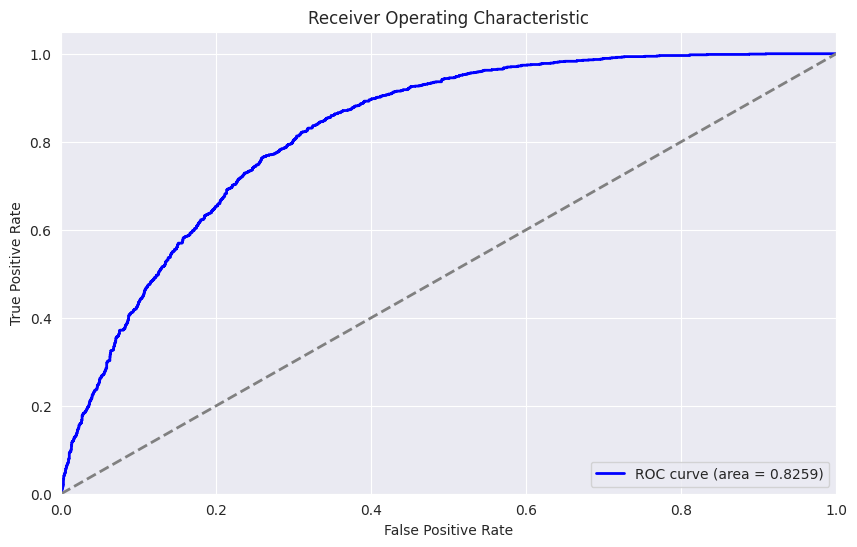

/tmp/ipykernel_2637/1220225284.py:107: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  default_samples['param_max_depth'] = default_samples['param_max_depth'].fillna(-1)
/tmp/ipykernel_2637/1220225284.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  default_samples['param_max_depth'] = default_samples['param_max_depth'].fillna(-1)


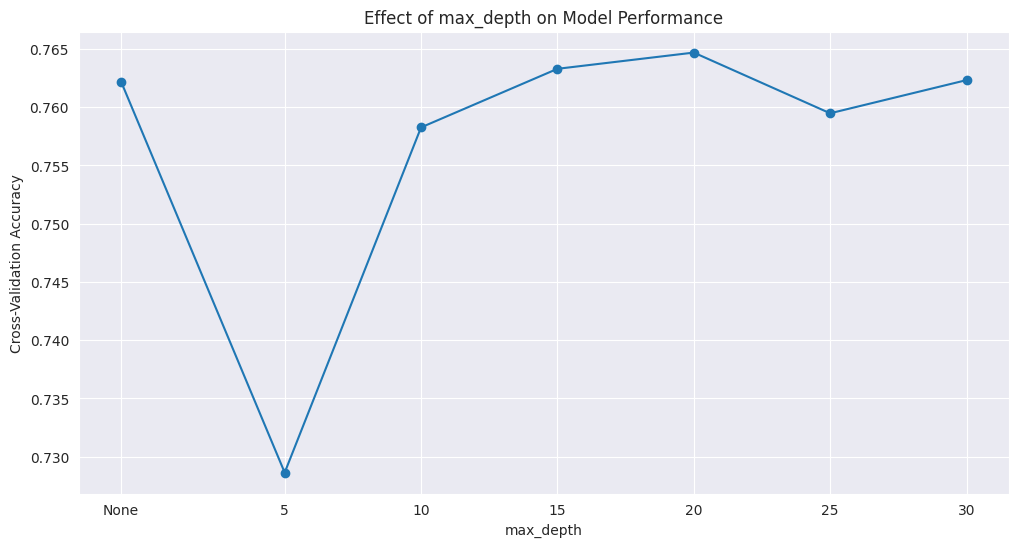

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Get the optimal features we found
optimal_features = ['goal', 'create_to_launch_days', 'launch_to_state_change_days', 'created_at_hr', 'created_at_day', 'name_len_clean', 'blurb_len_clean', 'launched_at_day', 'launched_at_hr', 'category_Web', 'launch_to_deadline_days', 'state_changed_at_day', 'deadline_hr', 'deadline_day', 'state_changed_at_hr', 'created_at_month', 'category_Software', 'launched_at_month', 'deadline_month', 'state_changed_at_month', 'category_Hardware', 'launched_at_weekday_Tuesday', 'created_at_weekday_Tuesday', 'category_None', 'created_at_weekday_Monday', 'created_at_weekday_Friday', 'created_at_weekday_Thursday', 'category_Plays', 'created_at_weekday_Wednesday']

# Train the model using optimal features
X_train_optimal = X_train[optimal_features]
X_test_optimal = X_test[optimal_features]


# Define parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create base model
base_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Setup Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Perform Grid Search
grid_search.fit(X_train_optimal, y_train)

# Get best parameters and best model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Make predictions with the best model
y_pred = best_rf_model.predict(X_test_optimal)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Feature importance of the final model
feature_importance = best_rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': optimal_features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df.head(10))  # Show top 10 features

# Calculate cross-validation score for the best model
cv_scores = cross_val_score(
    best_rf_model,
    X[optimal_features], Y1,
    cv=5, scoring='accuracy'
)
print(f"\nCross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Plot ROC curve
y_pred_proba = best_rf_model.predict_proba(X_test_optimal)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2,
         label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Visualize hyperparameter tuning results
results = pd.DataFrame(grid_search.cv_results_)

# Plot accuracy for different max_depth values
plt.figure(figsize=(12, 6))

# Filter results for default min_samples values
default_samples = results[(results['param_min_samples_split'] == 2) &
                         (results['param_min_samples_leaf'] == 1)]

# Convert None to -1 for plotting purposes
default_samples['param_max_depth'] = default_samples['param_max_depth'].fillna(-1)

# Sort by max_depth for proper x-axis order
default_samples = default_samples.sort_values('param_max_depth')

plt.plot(default_samples['param_max_depth'],
         default_samples['mean_test_score'],
         marker='o', linestyle='-')

# Replace -1 with "None" in xticks
x_ticks = default_samples['param_max_depth'].unique()
x_labels = [str(int(x)) if x > 0 else "None" for x in x_ticks]

plt.xticks(x_ticks, x_labels)
plt.xlabel('max_depth')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Effect of max_depth on Model Performance')
plt.grid(True)
plt.show()